In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install shapely
!pip install patchify
!pip install albumentations
!pip install segmentation-models
# !pip install keras-unet-collection
# !pip install geopandas

     |████████████████████████████████| 631 kB 5.3 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654020 sha256=b13b0473ddcc0f138c0a83d57abe0b8db8f27b27ae373ea58b1bf6bf61df9b72
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 50 kB 4.1 MB/s 


In [ ]:
import os
import json
import shapely.ops as so
import matplotlib.pyplot as plt
import numpy as np
import io
import skimage
import random
import gc
import datetime
import segmentation_models as sm
import tensorflow as tf
# import geopandas as gpd

from shapely import wkt
from PIL import Image
from tqdm import tqdm
from skimage.draw import polygon
from skimage import color
from skimage import io as skio
from patchify import patchify
from albumentations import  RandomRotate90, GridDistortion,VerticalFlip,HorizontalFlip
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam
# from keras_unet_collection import models, losses

Segmentation Models: using `keras` framework.


In [ ]:
## there's some issue with tf version
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [ ]:
#setting data type policy
mixed_precision.set_global_policy('mixed_float16')

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
path='/content/drive/MyDrive/VBL Dataset/VisionBeyondLimits/'

In [ ]:
im_path=path+'Images'
la_path=path+'Labels'

In [ ]:
n_im=len(os.listdir(im_path))
n_la=len(os.listdir(la_path))

In [ ]:
print(n_im)
print(n_la)

117
117


In [ ]:
IMG_HEIGHT=256
IMG_WIDTH=256
IMG_CHANNELS=3
batch_size=16

SEED=45
random.seed(SEED)

In [ ]:
X=np.zeros((n_im,1024,1024,3),dtype=np.uint8)
Y=np.zeros((n_im,1024,1024),dtype=np.uint8)

Transforming the jsons

In [ ]:
lst=os.listdir(la_path)
lst.sort()

In [ ]:
# i=1
# for file in tqdm(lst): # files
#   # print("File ",file, " under analysis; ")

#   f=open(la_path+'/'+file)
#   data=json.load(f)
#   xy=data['features']['xy']
#   # print(type(xy))

#   for poly in xy:
#     category=poly['properties']['subtype']
#     p=wkt.loads(poly['wkt'])
#     # print(p)


#   # print(117-i," left")
#   i+=1

In [ ]:
# print(type(p))

In [ ]:
# p

In [ ]:
## check category types
catset=set()
for file in tqdm(lst): # files
  # print("File ",file, " under analysis; ")

  f=open(la_path+'/'+file)
  data=json.load(f)
  xy=data['features']['xy']
  # print(type(xy))

  for poly in xy:
    category=poly['properties']['subtype']
    p=wkt.loads(poly['wkt'])
    # print(category)
    catset.add(category)


100%|██████████| 117/117 [00:03<00:00, 30.36it/s]


In [ ]:
catset

{'destroyed', 'major-damage', 'minor-damage', 'no-damage', 'un-classified'}

In [ ]:
imagelist=os.listdir(im_path)
imagelist.sort()

In [ ]:
def augment(image,mask,augment=True):
  if augment==True:

    # aug=RandomRotate90(p=1.0)
    # augmented=aug(image=image,mask=mask)
    # x1=augmented["image"]
    # y1=augmented["mask"]

    # aug=GridDistortion(p=1.0)
    # augmented=aug(image=image,mask=mask)
    # x2=augmented["image"]
    # y2=augmented["mask"]

    # aug=HorizontalFlip(p=1.0)
    # augmented=aug(image=image,mask=mask)
    # x3=augmented["image"]
    # y3=augmented["mask"]

    # aug=VerticalFlip(p=1.0)
    # augmented=aug(image=image,mask=mask)
    # x4=augmented["image"]
    # y4=augmented["mask"]

  # return [image,x1,x2,x3,x4],[mask,y1,y2,y3,y4] #  flips on
  # return [image,x1,x2],[mask,y1,y2] #  flips off
  # return [image,x1],[mask,y1] #  flips,grid dist  off
    return [image],[mask] #  no augmentation

In [ ]:
i=1
for file in tqdm(lst): # files

  imim=skio.imread(im_path+'/'+imagelist[i-1]) # the image
  imar=np.array(imim,dtype=np.uint8)
  X[i-1]=imar # coresponding np array

  print("File ",file, " under analysis; ")

  f=open(la_path+'/'+file) # coresponding json
  data=json.load(f)
  xy=data['features']['xy']
  # print(type(xy))

  shape=[]
  category=[]
  for poly in xy:
    category.append(poly['properties']['subtype'])
    p=wkt.loads(poly['wkt'])
    # p=gpd.GeoSeries(p)
    shape.append(p)

  # shape=so.cascaded_union(shape)
  # fig, axs = plt.subplots()


  mask=np.zeros((1024,1024))

  j=0
  print(len(shape)," polygons found")
  for poly in shape:
    poly_coordinates=np.array(list(poly.exterior.coords))
    rr,cc=polygon(poly_coordinates[:,0],poly_coordinates[:,1],(1024,1024));

    cat=category[j]

    if cat=='destroyed':
      val=1
    if cat=='major-damage':
      val=2
    if cat=='minor-damage':
      val=3
    if cat=='no-damage':
      val=4
    if cat=='un-classified':
      val=5
    
    mask[cc,rr]=val
    j+=1

  # mask=255*mask
  # mask=np.dstack((mask,mask,mask))
  # masked_image=Image.fromarray(mask,'RGB')

  Y[i-1]=mask

  masked_image=Image.fromarray(255*mask)

  print("size of image is ",masked_image.size)
  # plt.imshow(masked_image)
  skimage.io.imshow(color.label2rgb(mask,image=imim,bg_label=1,kind='overlay'))
  plt.show()

 




  print(117-i," left")
  i+=1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
## cleaning list
del lst
gc.collect()

53655

(1024, 1024, 3)


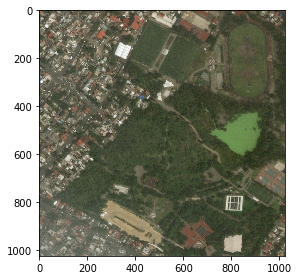

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  import sys


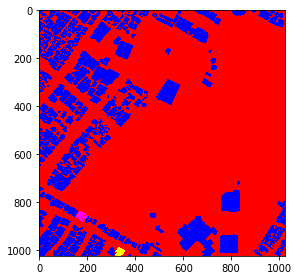

In [ ]:
# sanity check 1
a=random.randint(0,n_im-1)

print(X[a].shape)
skio.imshow(X[a])
plt.show()
skio.imshow(color.label2rgb(255*Y[a]))

Splitting dataset

In [ ]:
# train_test split
X_tr, X_test, Y_tr, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 42)

In [ ]:
X_tr.shape

(81, 1024, 1024, 3)

In [ ]:
# valid split
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size = 0.65, random_state = 42)

In [ ]:
print(X_test.shape)
print(X_val.shape)

(24, 1024, 1024, 3)
(12, 1024, 1024, 3)


In [ ]:
## cleaning X,Y 
del X
del Y
gc.collect()

2579

In [ ]:
## one image => 16 patches => (1+(n_aug-1)) augmentations for each
n_aug=1 ## no of augmentations => orig n_aug=5 if all augmentatins on; 1 if all augmentations off
X_train=tf.Variable(tf.zeros((X_tr.shape[0]*16*n_aug,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8))
Y_train=tf.Variable(tf.zeros((Y_tr.shape[0]*16*n_aug,IMG_HEIGHT,IMG_WIDTH),dtype=np.uint8))

In [ ]:
print(X_train.shape)
print(Y_train.shape)

(1296, 256, 256, 3)
(1296, 256, 256)


Data Augmentation and Preprocessing

In [ ]:
i=0
for im, ma in tqdm(zip(X_tr,Y_tr),total=X_tr.shape[0]):

  ## depatching
  patches_img=patchify(im,(256,256,3),step=(256))
  patches_lab=patchify(ma,(256,256),step=(256))

  # print(patches_lab.shape)

  ## augmenting and saving

  for p in range(patches_img.shape[0]):
    for q in range(patches_img.shape[1]):
      single_im_patch=patches_img[p,q,:,:,:]
      single_la_patch=patches_lab[p,q,:,:]

      single_im_patch=np.squeeze(single_im_patch)
      single_la_patch=np.squeeze(single_la_patch)

      augx,augy=augment(single_im_patch,single_la_patch) # augx & y are a list of len n_aug

      
      for j in range(n_aug):
        X_train[i+j].assign(augx[j])
      for j in range(n_aug):
        Y_train[i+j].assign(augy[j])

      i+=n_aug
    

100%|██████████| 81/81 [02:42<00:00,  2.01s/it]


In [ ]:
## cleaning X,Y 
del X_tr
del Y_tr
gc.collect()

50

In [ ]:
tf.random.shuffle(X_train, seed=SEED)
tf.random.shuffle(Y_train, seed=SEED)

<tf.Tensor: shape=(1296, 256, 256), dtype=uint8, numpy=
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 0, 4, 4]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0

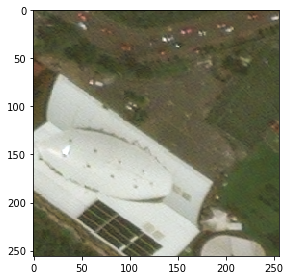

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  import sys


(256, 256, 3)
(256, 256)


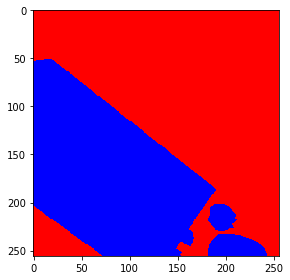

In [ ]:
#sanity check 2
a=random.randint(0,X_train.shape[0])
im=X_train[a].numpy()
skio.imshow(im)
plt.show()
ma=Y_train[a].numpy()
skio.imshow(color.label2rgb(255*ma))
print(X_train[a].shape)
print(Y_train[a].shape)

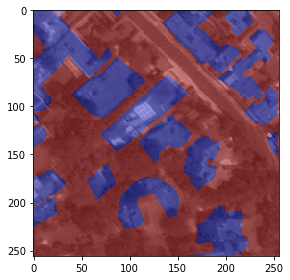

In [ ]:
#sanity check 3
a=random.randint(0,X_train.shape[0])
skimage.io.imshow(color.label2rgb(Y_train[a].numpy(),image=X_train[a].numpy(),bg_label=1,kind='overlay'))
plt.show()

In [ ]:
print(X_train[0].shape)
print(Y_train[0].shape)

(256, 256, 3)
(256, 256)


In [ ]:
n_classes=len(np.unique(Y_train)) # includes background as well # bg # destroyed # maj dam # min dam # no dam # unclassi
print(n_classes)

6


In [ ]:
# converts to categorical one hot encoding
Y_train=tf.convert_to_tensor(to_categorical(Y_train,num_classes=n_classes,dtype='float16'))  ## things geting brrrrrrr here...memory mismanagement ## partially solved

In [ ]:
Y_train.shape

TensorShape([1296, 256, 256, 6])

In [ ]:
X_valid=tf.Variable(tf.zeros((X_val.shape[0]*16,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8))
Y_valid=tf.Variable(tf.zeros((Y_val.shape[0]*16,IMG_HEIGHT,IMG_WIDTH),dtype=np.uint8))

In [ ]:
## Processing validation data
i=0
for im, ma in tqdm(zip(X_val,Y_val),total=X_val.shape[0]):

  ## depatching
  patches_img=patchify(im,(256,256,3),step=(256))
  patches_lab=patchify(ma,(256,256),step=(256))


  for p in range(patches_img.shape[0]):
    for q in range(patches_img.shape[1]):
      single_im_patch=patches_img[p,q,:,:,:]
      single_la_patch=patches_lab[p,q,:,:]

      single_im_patch=np.squeeze(single_im_patch)
      single_la_patch=np.squeeze(single_la_patch)
      
      # print(single_im_patch.shape, "   ",single_la_patch.shape)
      X_valid[i].assign(single_im_patch)
      Y_valid[i].assign(single_la_patch)

      i+=1

100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


In [ ]:
tf.random.shuffle(X_valid, seed=SEED)
tf.random.shuffle(Y_valid, seed=SEED)

<tf.Tensor: shape=(192, 256, 256), dtype=uint8, numpy=
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[4, 4, 4, ..., 4, 4, 0],
        [4, 4, 4, ..., 4, 4, 0],
        [4, 4, 4, ..., 4, 4, 0],
        ...,
        [4, 4, 4, ..., 4, 4, 0],
        [4, 4, 4, ..., 4, 4, 0],
        [4, 4, 4, ..., 4, 4, 0]],

       [[4, 4, 4, ..., 0, 0, 0],
        [4, 4, 4, ..., 0, 0, 0],
        [4, 4, 4, ..., 0, 0, 0],
        ...,
        [3, 3, 3, ..., 0, 0, 0],
        [3, 3, 3, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 0, 0, 0],
        [4, 4, 4, ..., 0, 0, 0],
        [4, 4, 4, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [4, 4, 4, ..., 4, 4, 0],
        [4, 4,

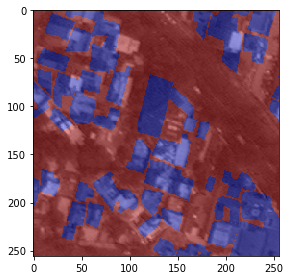

In [ ]:
#sanity check 4
a=random.randint(0,X_valid.shape[0])
skimage.io.imshow(color.label2rgb(Y_valid[a].numpy().astype(np.uint8),image=X_valid[a].numpy().astype(np.uint8),bg_label=1,kind='overlay'))
plt.show()

In [ ]:
del X_val
del Y_val
gc.collect()

9366

In [ ]:
# converts validation to categorical one hot encoding
Y_valid=tf.convert_to_tensor(to_categorical(Y_valid,num_classes=n_classes,dtype='float16'))

In [ ]:
print(Y_valid.shape)

(192, 256, 256, 6)


In [ ]:
# Normalise
tf.cast(X_train,dtype=tf.float16)
X_train=(X_train/255)

tf.cast(X_valid,dtype=tf.float16)
X_valid=(X_valid/255)

tf.cast(Y_train,dtype=tf.float16)

tf.cast(Y_valid,dtype=tf.float16)


<tf.Tensor: shape=(192, 256, 256, 6), dtype=float16, numpy=
array([[[[1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         ...,
         [1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         ...,
         [1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         ...,
         [1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.]],

        ...,

        [[1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         ...,
         [1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 

In [ ]:
print(np.max(X_train),np.min(X_train))

1.0 0.0


In [ ]:
print(type(X_train))
print(type(Y_train))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
print(np.unique(Y_valid[0]))

[0. 1.]


# Model assembling (From Segmentation Models)

In [ ]:
# a custom loss function
def tversky_index(y_true, y_pred):
    # generalization of dice coefficient algorithm
    #   alpha corresponds to emphasis on False Positives
    #   beta corresponds to emphasis on False Negatives (our focus)
    #   if alpha = beta = 0.5, then same as dice
    #   if alpha = beta = 1.0, then same as IoU/Jaccard
    alpha = 0.5
    beta = 0.5

    tf.make_ndarray(y_true)
    tf.make_ndarray(y_pred)

    y_true_f = np.flatten(y_true)
    y_pred_f = np.flatten(y_pred)
    intersection = np.sum(y_true_f * y_pred_f)
    return (intersection) / (intersection + alpha * (np.sum(y_pred_f*(1. - y_true_f))) + beta *  (np.sum((1-y_pred_f)*y_true_f)))

def tversky_index_loss(y_true, y_pred):
  return -tversky_index(y_true, y_pred)

In [ ]:
BACKBONE = 'resnet34'
# BACKBONE = 'vgg19'
epochs=30
lr=0.1

weights=weights = [0.5, 0.05, 0.05, 0.05, 0.3, 0.05]

# losss=sm.losses.bce_jaccard_loss
losss=sm.losses.CategoricalCELoss(class_weights=weights)
# losss=tversky_index_loss
# losss=(5*sm.losses.CategoricalCELoss(class_weights=weights))+sm.losses.DiceLoss(class_weights=weights)

preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train = preprocess_input(X_train)
X_valid = preprocess_input(X_valid)

# define model
model = sm.Unet(BACKBONE,classes=n_classes,activation='softmax', encoder_weights='imagenet',encoder_freeze=True,input_shape=(256, 256, 3),decoder_use_batchnorm=True)

#model compiling
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=losss, metrics=[sm.metrics.iou_score])

85532672/85521592 [==============================] - 1s 0us/step


In [ ]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']   

In [ ]:
def lr_scheduler(epochs, lr):
    decay_rate = 0.1
    decay_step = 8
    if epochs % decay_step == 0 and epochs:
        return lr * decay_rate
    return lr

start1 = datetime.datetime.now() 

## model checkpoints
checkpointer=tf.keras.callbacks.ModelCheckpoint('unet_earthquake_30_2_epochs.h5',verbose=1,save_best_only=True)
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=6,monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    ]

## run
history=model.fit(X_train, 
          Y_train,
          validation_data=(X_valid,Y_valid),
          batch_size=32, 
          epochs=epochs,
          verbose=1,
          callbacks=callbacks)

stop1 = datetime.datetime.now()

## Execution time of the model 
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/30
41/41 [==============================] - 64s 980ms/step - loss: 0.1278 - iou_score: 0.0514 - val_loss: 0.1306 - val_iou_score: 0.0442 - lr: 0.1000
Epoch 2/30
41/41 [==============================] - 36s 870ms/step - loss: 0.1278 - iou_score: 0.0513 - val_loss: 0.1298 - val_iou_score: 0.0443 - lr: 0.1000
Epoch 3/30
41/41 [==============================] - 36s 870ms/step - loss: 0.1278 - iou_score: 0.0514 - val_loss: 0.1283 - val_iou_score: 0.0445 - lr: 0.1000
Epoch 4/30
41/41 [==============================] - 36s 887ms/step - loss: 0.1277 - iou_score: 0.0514 - val_loss: 0.1262 - val_iou_score: 0.0456 - lr: 0.1000
Epoch 5/30
41/41 [==============================] - 36s 870ms/step - loss: 0.1279 - iou_score: 0.0513 - val_loss: 0.1272 - val_iou_score: 0.0454 - lr: 0.1000
Epoch 6/30
41/41 [==============================] - 36s 868ms/step - loss: 0.1278 - iou_score: 0.0513 - val_loss: 0.1289 - val_iou_score: 0.0450 - lr: 0.1000
Epoch 7/30
41/41 [==============================] - 

In [ ]:
## saving
model.save('Earthquake_unet_30_epochs.hdf5')


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# clean memory
# del X_train
# del Y_train
# del X_valid
# del Y_valid
# gc.collect()

In [ ]:
X_te=tf.Variable(tf.zeros((X_test.shape[0]*16,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8))
Y_te=tf.Variable(tf.zeros((Y_test.shape[0]*16,IMG_HEIGHT,IMG_WIDTH),dtype=np.uint8))

In [ ]:
## Processing test data
i=0
for im, ma in tqdm(zip(X_test,Y_test),total=X_test.shape[0]):

  ## depatching
  patches_img=patchify(im,(256,256,3),step=(256))
  patches_lab=patchify(ma,(256,256),step=(256))


  for p in range(patches_img.shape[0]):
    for q in range(patches_img.shape[1]):
      single_im_patch=patches_img[p,q,:,:,:]
      single_la_patch=patches_lab[p,q,:,:]

      single_im_patch=np.squeeze(single_im_patch)
      single_la_patch=np.squeeze(single_la_patch)
      
      # print(single_im_patch.shape, "   ",single_la_patch.shape)
      X_te[i].assign(single_im_patch)
      Y_te[i].assign(single_la_patch)

      i+=1

100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


In [ ]:
# del X_test
# del Y_test
# gc.collect()

In [ ]:
X_te[0].shape

TensorShape([256, 256, 3])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  if __name__ == '__main__':


1/1 [==============================] - 0s 31ms/step
before  0.4485
before  (1, 256, 256, 6)
after  (256, 256)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


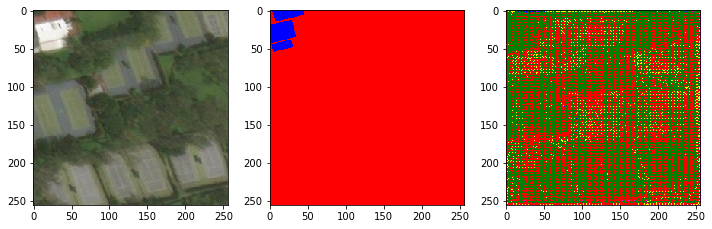

In [ ]:
a=random.randint(0,X_te.shape[0])

fig = plt.figure(figsize=(10, 8))

fig.add_subplot(1, 3, 1)
skio.imshow(X_te[a].numpy())

fig.add_subplot(1, 3, 2)
skio.imshow(color.label2rgb(255*Y_te[a].numpy()))

#predict random image
testet=tf.expand_dims(X_te[a],axis=0)
testet = preprocess_input(testet)
pred = model.predict(testet/255, verbose=1)

print("before ",np.max(pred))
print("before ",pred.shape)

pred=tf.squeeze(pred)
pred=tf.math.argmax(pred,axis=2)

pred = tf.keras.backend.eval(pred)

print("after ",pred.shape)

# pred=pred.numpy()

fig.add_subplot(1, 3, 3)
skio.imshow(color.label2rgb(255*pred))

plt.show()

In [ ]:
print(np.unique(Y_te[a].numpy()))
print(np.unique(pred))

[0 4]
[0 1 2 3 4 5]


Tensorboard checkup

In [ ]:
!tensorboard --logdir=logs/ --host localhost 


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


# Model training (Custom made)

In [ ]:
epochs=30
lr=0.1
activation_fu='tanh'
epochs=30
# losss=sm.losses.bce_jaccard_loss
weights=weights = [0.5, 0.05, 0.05, 0.05, 0.3, 0.05]
losss=sm.losses.CategoricalCELoss(class_weights=weights)

In [ ]:
# Model
inputs=tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
# s=tf.keras.layers.Lambda(lambda x: x/255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=activation_fu, kernel_initializer='he_normal', padding='same')(c9)
 
outputs=tf.keras.layers.Conv2D(n_classes,(1,1),activation='softmax')(c9)

model=tf.keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),loss=losss,metrics=[sm.metrics.iou_score])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                           

In [ ]:
def lr_scheduler(epochs, lr):
    decay_rate = 0.1
    decay_step = 5
    if epochs % decay_step == 0 and epochs:
        return lr * decay_rate
    return lr

start1 = datetime.datetime.now() 

## model checkpoints
checkpointer=tf.keras.callbacks.ModelCheckpoint('unet_earthquake_25_epochs.h5',verbose=1,save_best_only=True)
callbacks=[
    # tf.keras.callbacks.EarlyStopping(patience=4,monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    ]

## run
history=model.fit(X_train, 
          Y_train,
          validation_data=(X_valid,Y_valid),
          batch_size=64, 
          epochs=epochs,
          verbose=1,
          callbacks=callbacks)

stop1 = datetime.datetime.now()

## Execution time of the model 
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)

In [ ]:
a=random.randint(0,X_te.shape[0])

fig = plt.figure(figsize=(10, 8))

fig.add_subplot(1, 3, 1)
skio.imshow(X_te[a].numpy())

fig.add_subplot(1, 3, 2)
skio.imshow(color.label2rgb(255*Y_te[a].numpy()))

#predict random image
testet=tf.expand_dims(X_te[a],axis=0)
pred = model.predict(testet, verbose=1)

print("before ",np.max(pred))
print("before ",pred.shape)

pred=tf.squeeze(pred)
pred=tf.math.argmax(pred,axis=2)

pred = tf.keras.backend.eval(pred)

print("after ",pred.shape)

# pred=pred.numpy()

fig.add_subplot(1, 3, 3)
skio.imshow(color.label2rgb(255*pred))

plt.show()

Ignore later parts

In [ ]:
# # WORKING but No Need RN
# i=1
# for file in tqdm(lst): # files  ## lst cleaned out so will throw an error
#   imim=skio.imread(im_path+'/'+imagelist[i-1])
#   print("File ",file, " under analysis; ")

#   f=open(la_path+'/'+file)
#   data=json.load(f)
#   xy=data['features']['xy']
#   # print(type(xy))

#   shape=[]
#   category=[]
#   for poly in xy:
#     category.append(poly['properties']['subtype'])
#     p=wkt.loads(poly['wkt'])
#     # p=gpd.GeoSeries(p)
#     shape.append(p)

#   # shape=so.cascaded_union(shape)
#   # fig, axs = plt.subplots()


#   mask=np.zeros((1024,1024))

#   j=0
#   print(len(shape)," polygons found")
#   for poly in shape:
#     poly_coordinates=np.array(list(poly.exterior.coords))
#     rr,cc=polygon(poly_coordinates[:,0],poly_coordinates[:,1],(1024,1024));

#     cat=category[j]

#     if cat=='destroyed':
#       val=1
#     if cat=='major-damage':
#       val=2#model checkpoints
# checkpointer=tf.keras.callbacks.ModelCheckpoint('unet_earthquake_25_epochs.h5',verbose=1,save_best_only=True)
# callbacks=[
#     tf.keras.callbacks.EarlyStopping(patience=4,monitor='val_loss'),
#     tf.keras.callbacks.TensorBoard(log_dir='logs')]

# results=model.fit(X_train,Y_train,validation_data=(X_valid,Y_valid),batch_size=8,epochs=25,callbacks=callbacks)
#     if cat=='minor-damage':
#       val=3
#     if cat=='no-damage':
#       val=4
#     if cat=='un-classified':
#       val=5
    
#     mask[cc,rr]=val
#     j+=1

#   # mask=255*mask
#   # mask=np.dstack((mask,mask,mask))
#   # masked_image=Image.fromarray(mask,'RGB')

#   masked_image=Image.fromarray(255*mask)

#   print("size of image is ",masked_image.size)
#   # plt.imshow(masked_image)
#   skimage.io.imshow(color.label2rgb(mask,image=imim,bg_label=1,kind='overlay'))
#   plt.show()

 




#   print(117-i," left")
#   i+=1

In [ ]:
# lst2=os.listdir(im_path)

# i=0
# for files in lst2:
#   if i==30: break
#   im=Image.open(im_path+'/'+files)
#   pix=np.array(im)
#   print(pix.shape)
#   i+=1

In [ ]:
# a=X_train[0:50,:,:,:]
# b=Y_train[0:50,:,:,:]

# c=X_valid[0:10,:,:,:]
# d=Y_valid[0:10,:,:,:]

# # BACKBONE = 'resnet34'
# BACKBONE = 'vgg16'
# epochs=30
# lr=0.1

# weights=weights = [0.5, 0.05, 0.05, 0.05, 0.3, 0.05]

# # losss=sm.losses.bce_jaccard_loss
# losss=sm.losses.CategoricalCELoss(class_weights=weights)
# # losss=tversky_index_loss
# # losss=(5*sm.losses.CategoricalCELoss(class_weights=weights))+sm.losses.DiceLoss(class_weights=weights)

# preprocess_input = sm.get_preprocessing(BACKBONE)

# # preprocess input
# X_train = preprocess_input(a)
# X_valid = preprocess_input(c)

# # define model
# model = sm.Linknet(BACKBONE,classes=n_classes,activation='softmax', encoder_weights='imagenet',encoder_freeze=True,input_shape=(256, 256, 3),decoder_use_batchnorm=True)

# #model compiling
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=losss, metrics=[sm.metrics.iou_score])

In [ ]:
# print(model.summary())

In [ ]:
# def lr_scheduler(epochs, lr):
#     decay_rate = 0.1
#     decay_step = 8
#     if epochs % decay_step == 0 and epochs:
#         return lr * decay_rate
#     return lr

# start1 = datetime.datetime.now() 

# ## model checkpoints
# checkpointer=tf.keras.callbacks.ModelCheckpoint('unet_earthquake_30_2_epochs.h5',verbose=1,save_best_only=True)
# callbacks=[
#     # tf.keras.callbacks.EarlyStopping(patience=6,monitor='val_loss'),
#     tf.keras.callbacks.TensorBoard(log_dir='logs'),
#     tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
#     ]

# ## run
# history=model.fit(a, 
#           b,
#           validation_data=(c,d),
#           batch_size=32, 
#           epochs=epochs,
#           verbose=1,
#           callbacks=callbacks)

# stop1 = datetime.datetime.now()

# ## Execution time of the model 
# execution_time_Unet = stop1-start1
# print("UNet execution time is: ", execution_time_Unet)